In [ ]:
import gensim
import pandas as pd
import keras
import pickle
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv(r"/content/drive/MyDrive/processed_dataset.csv", squeeze = True, header = 0)

In [ ]:
data = data[["Transcripts", "Class"]]

In [ ]:
len(data)

20000

In [ ]:
data.head()

,Transcripts,Class
0,matter time til .wait ..,0
1,good website suicidal people go.,0
2,moment say happy still ..,0
3,basically reason live .adios.,0
4,need help right lose.,0


In [ ]:
data = data.sample(frac = 1)
data.head()

,Transcripts,Class
5268,experience use part tfx cant decide whether go...,0
1216,mean anyone brought light darkness ..,0
1226,anyone know stream dl folle folle fólleme tim ...,0
11620,saved two nice bag plastic aluminum recyclable...,0
10453,curious luke struck force lightening become di...,0


In [ ]:
Y= data.iloc[:,1].values
Y

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
###Manually resolve the tabbed data errors

index = [791,  792,  793,  830,  831,  832,  833,  839,  844, 846, 852,  853,
         855,  858,  860,  876,  882,  890,  892,  904,  909,  912,  936,
         938,  943,  945,  957,  964,  965,  967,  969,  972,  975,  976,
        1000, 1007, 1013, 1018, 1297] 
for i in index:
    Y[i] = 0  ###replace value of selected indices of AD column with 0

idx = [1072, 1101, 1184, 1244]
for i in idx:
    Y[i] = 1  ###replace value of selected indices of AD column with 1
Y = Y.astype(int)

In [ ]:
X = data['Transcripts'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2,random_state = 0) ##split the data in training and testing

In [ ]:
print(len(X_train)) ###length of training, testing data
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

16000
4000
16000
4000


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [ ]:
train_tokenizer = create_tokens(X_train)

In [ ]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X

In [ ]:
X_train = encode_sentences(train_tokenizer,100, X_train)
X_test = encode_sentences(train_tokenizer,100, X_test)

In [ ]:
print(X_train.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(16000, 100)
(4000, 100)
(16000,)
(4000,)


In [ ]:
vocab_len= len(train_tokenizer.word_index ) + 1 
vocab_len   ###vocab length

13336

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense 
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm

In [ ]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =256, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Epoch 1/25
113/113 [==============================] - 13s 25ms/step - loss: 0.4435 - accuracy: 0.7776 - val_loss: 0.2877 - val_accuracy: 0.8900
Epoch 2/25
113/113 [==============================] - 2s 20ms/step - loss: 0.2139 - accuracy: 0.9190 - val_loss: 0.2667 - val_accuracy: 0.8925
Epoch 3/25
113/113 [==============================] - 2s 20ms/step - loss: 0.1583 - accuracy: 0.9426 - val_loss: 0.2854 - val_accuracy: 0.8931
Epoch 4/25
113/113 [==============================] - 2s 20ms/step - loss: 0.1187 - accuracy: 0.9587 - val_loss: 0.2980 - val_accuracy: 0.8875
Epoch 5/25
113/113 [==============================] - 2s 20ms/step - loss: 0.0848 - accuracy: 0.9717 - val_loss: 0.3621 - val_accuracy: 0.8781
Epoch 6/25
 67/113 [================>.............] - ETA: 0s - loss: 0.0513 - accuracy: 0.9846

KeyboardInterrupt: ignored

In [ ]:
score = model.evaluate(X_test,Y_test,verbose = 1)

125/125 [==============================] - 1s 3ms/step - loss: 1.8102 - accuracy: 0.8677


In [ ]:
print('Accuracy of the model is {}'.format(score[1]))

Accuracy of the model is 0.8677499890327454


In [ ]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[2226  185]
 [ 344 1245]]
precision is 0.8706293706293706
recall is  0.7835116425424795
F1 score 0.8247764160317986
specificity is 0.9232683533803401


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f = X_train[train_idx]
    y_train_f = Y_train[train_idx]
    x_val_f = X_train[val_idx]
    y_val_f = Y_train[val_idx]
    model.fit(x_train_f, y_train_f,
              batch_size=256,
              epochs=5,
              verbose = 0,
              validation_data=(x_val_f, y_val_f))
    # Get accuracy of model on validation data. It's not AUC but it's something at least!
    preds_val = model.predict([x_val_f], batch_size=256)
    preds.append(model.predict(X_test))
    fold = fold + 1
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=0)
    aucs = aucs + auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=1)
    aucs += auc(fpr,tpr)
    print('Fold {}, AUC = {}'.format(fold,auc(fpr, tpr)))
print("Cross Validation AUC = {}".format(aucs/10))  

Fold 1, AUC = 0.9937524325046125
Fold 2, AUC = 0.9999950654567166
Fold 3, AUC = 1.0
Fold 4, AUC = 1.0
Fold 5, AUC = 1.0
Fold 6, AUC = 1.0
Fold 7, AUC = 1.0
Fold 8, AUC = 1.0
Fold 9, AUC = 1.0
Fold 10, AUC = 1.0
Cross Validation AUC = 1.0


In [ ]:
def model_cnn_create(neurons = 128, optimizer = 'Adam',
                 dropout_rate = 0.2, weight_constraint = 3, nb_filters = 256, kernel_size = 5):
    
    model = Sequential()
    model.add(Embedding(input_dim = vocab_len, output_dim = 100, input_length = 100))
    model.add(Conv1D(nb_filters, kernel_size, activation = 'relu',strides = 1, kernel_initializer= 'he_uniform'))   
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(units = neurons, kernel_constraint=maxnorm(weight_constraint),kernel_initializer= 'he_uniform', activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))   
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
param_grid = {
    'optimizer': ['RMSprop','Adam','SGD'],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 5)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] optimizer=RMSprop ...............................................
Epoch 1/5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


400/400 - 4s - loss: 0.3880 - accuracy: 0.8223
Epoch 2/5
400/400 - 3s - loss: 0.2097 - accuracy: 0.9230
Epoch 3/5
400/400 - 3s - loss: 0.1431 - accuracy: 0.9513
Epoch 4/5
400/400 - 3s - loss: 0.0830 - accuracy: 0.9732
Epoch 5/5
400/400 - 3s - loss: 0.0460 - accuracy: 0.9851
100/100 - 0s - loss: 0.5648 - accuracy: 0.8519
[CV] ................................ optimizer=RMSprop, total=  16.7s
[CV] optimizer=RMSprop ...............................................
Epoch 1/5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s


400/400 - 4s - loss: 0.3626 - accuracy: 0.8395
Epoch 2/5
400/400 - 3s - loss: 0.2044 - accuracy: 0.9245
Epoch 3/5
400/400 - 3s - loss: 0.1292 - accuracy: 0.9548
Epoch 4/5
400/400 - 3s - loss: 0.0715 - accuracy: 0.9787
Epoch 5/5
400/400 - 3s - loss: 0.0358 - accuracy: 0.9889
100/100 - 0s - loss: 0.4952 - accuracy: 0.8650
[CV] ................................ optimizer=RMSprop, total=  16.6s
[CV] optimizer=RMSprop ...............................................
Epoch 1/5
400/400 - 4s - loss: 0.3801 - accuracy: 0.8290
Epoch 2/5
400/400 - 3s - loss: 0.2120 - accuracy: 0.9205
Epoch 3/5
400/400 - 3s - loss: 0.1420 - accuracy: 0.9514
Epoch 4/5
400/400 - 3s - loss: 0.0805 - accuracy: 0.9750
Epoch 5/5
400/400 - 3s - loss: 0.0424 - accuracy: 0.9874
100/100 - 0s - loss: 0.5333 - accuracy: 0.8484
[CV] ................................ optimizer=RMSprop, total=  15.7s
[CV] optimizer=RMSprop ...............................................
Epoch 1/5
400/400 - 4s - loss: 0.3877 - accuracy: 0.8217
Epoch

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  4.7min finished


500/500 - 8s - loss: 0.3578 - accuracy: 0.8388
Epoch 2/5
500/500 - 7s - loss: 0.1527 - accuracy: 0.9449
Epoch 3/5
500/500 - 7s - loss: 0.0700 - accuracy: 0.9777
Epoch 4/5
500/500 - 7s - loss: 0.0361 - accuracy: 0.9887
Epoch 5/5
500/500 - 7s - loss: 0.0206 - accuracy: 0.9938
Best accuracy:  0.8656249880790711
Best parameters:  {'optimizer': 'Adam'}


In [ ]:
param_grid = {
    'dropout_rate':[0.1,0.2,0.3,0.4,0.5],
    'weight_constraint':[1,2,3,4,5],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 5)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] dropout_rate=0.1, weight_constraint=1 ...........................
Epoch 1/5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


400/400 - 6s - loss: 0.3745 - accuracy: 0.8238
Epoch 2/5
400/400 - 5s - loss: 0.1610 - accuracy: 0.9420
Epoch 3/5
400/400 - 5s - loss: 0.0717 - accuracy: 0.9777
Epoch 4/5
400/400 - 5s - loss: 0.0356 - accuracy: 0.9883
Epoch 5/5
400/400 - 5s - loss: 0.0214 - accuracy: 0.9934
100/100 - 0s - loss: 0.5320 - accuracy: 0.8659
[CV] ............ dropout_rate=0.1, weight_constraint=1, total=  28.7s
[CV] dropout_rate=0.1, weight_constraint=1 ...........................
Epoch 1/5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.7s remaining:    0.0s


400/400 - 6s - loss: 0.3762 - accuracy: 0.8230
Epoch 2/5
400/400 - 5s - loss: 0.1640 - accuracy: 0.9423
Epoch 3/5
400/400 - 5s - loss: 0.0830 - accuracy: 0.9734
Epoch 4/5
400/400 - 5s - loss: 0.0424 - accuracy: 0.9872
Epoch 5/5
400/400 - 5s - loss: 0.0233 - accuracy: 0.9929
100/100 - 0s - loss: 0.5481 - accuracy: 0.8637
[CV] ............ dropout_rate=0.1, weight_constraint=1, total=  28.4s
[CV] dropout_rate=0.1, weight_constraint=1 ...........................
Epoch 1/5
400/400 - 6s - loss: 0.3787 - accuracy: 0.8275
Epoch 2/5
400/400 - 5s - loss: 0.1625 - accuracy: 0.9406
Epoch 3/5
400/400 - 5s - loss: 0.0840 - accuracy: 0.9741
Epoch 4/5
400/400 - 5s - loss: 0.0451 - accuracy: 0.9860
Epoch 5/5
400/400 - 5s - loss: 0.0233 - accuracy: 0.9930
100/100 - 0s - loss: 0.5020 - accuracy: 0.8744
[CV] ............ dropout_rate=0.1, weight_constraint=1, total=  28.3s
[CV] dropout_rate=0.1, weight_constraint=1 ...........................
Epoch 1/5
400/400 - 6s - loss: 0.3832 - accuracy: 0.8226
Epoch

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 58.1min finished


500/500 - 7s - loss: 0.3475 - accuracy: 0.8473
Epoch 2/5
500/500 - 6s - loss: 0.1428 - accuracy: 0.9488
Epoch 3/5
500/500 - 6s - loss: 0.0656 - accuracy: 0.9794
Epoch 4/5
500/500 - 6s - loss: 0.0306 - accuracy: 0.9909
Epoch 5/5
500/500 - 6s - loss: 0.0211 - accuracy: 0.9927
Best accuracy:  0.8698750019073487
Best parameters:  {'dropout_rate': 0.5, 'weight_constraint': 5}


In [ ]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100)
model.add(e)
model.add(Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =128, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(4)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Epoch 1/25
113/113 [==============================] - 5s 31ms/step - loss: 0.5917 - accuracy: 0.6554 - val_loss: 0.3088 - val_accuracy: 0.8731
Epoch 2/25
113/113 [==============================] - 2s 20ms/step - loss: 0.1942 - accuracy: 0.9297 - val_loss: 0.2786 - val_accuracy: 0.8919
Epoch 3/25
113/113 [==============================] - 2s 21ms/step - loss: 0.1063 - accuracy: 0.9666 - val_loss: 0.3385 - val_accuracy: 0.8788
Epoch 4/25
113/113 [==============================] - 2s 21ms/step - loss: 0.0607 - accuracy: 0.9837 - val_loss: 0.3947 - val_accuracy: 0.8831
Epoch 5/25
113/113 [==============================] - 2s 22ms/step - loss: 0.0320 - accuracy: 0.9928 - val_loss: 0.5079 - val_accuracy: 0.8569
Epoch 6/25
113/113 [==============================] - 2s 22ms/step - loss: 0.0178 - accuracy: 0.9954 - val_loss: 0.5982 - val_accuracy: 0.8600
Epoch 7/25
113/113 [==============================] - 3s 22ms/step - loss: 0.0115 - accuracy: 0.9979 - val_loss: 0.6083 - val_accuracy: 0.8637

In [ ]:
score = model.evaluate(X_test,Y_test,verbose = 1)

125/125 [==============================] - 1s 3ms/step - loss: 0.9550 - accuracy: 0.8658


In [ ]:
print('Accuracy of the model is {}'.format(score[1]))     ###Accuracy on test data

Accuracy of the model is 0.8657500147819519


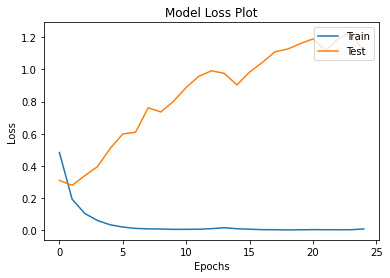

In [ ]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [ ]:
model.save('cnn_model.hdf5')   ###save the model

In [ ]:
from tensorflow.keras.models import load_model  ###load the model

In [ ]:
model.load_weights('cnn_model.hdf5')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
Y_pred=model.predict(X_test)
Y_pred =(Y_pred>0.5)

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[2195  216]
 [ 321 1268]]
precision is 0.8544474393530997
recall is  0.7979861548143486
F1 score 0.825252196550602
specificity is 0.9104106180008296


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


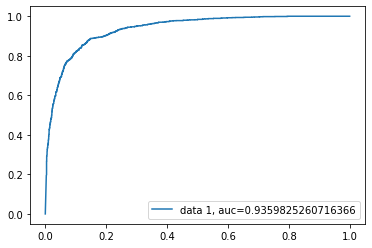

In [ ]:
Y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f = X_train[train_idx]
    y_train_f = Y_train[train_idx]
    x_val_f = X_train[val_idx]
    y_val_f = Y_train[val_idx]
    model.fit(x_train_f, y_train_f,
              batch_size=256,
              epochs=5,
              verbose = 0,
              validation_data=(x_val_f, y_val_f))
    # Get accuracy of model on validation data. It's not AUC but it's something at least!
    preds_val = model.predict([x_val_f], batch_size=256)
    preds.append(model.predict(X_test))
    fold = fold + 1
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=0)
    aucs = aucs + auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=1)
    aucs += auc(fpr,tpr)
    print('Fold {}, AUC = {}'.format(fold,auc(fpr, tpr)))
print("Cross Validation AUC = {}".format(aucs/10))  

Fold 1, AUC = 0.9937662743718642
Fold 2, AUC = 1.0
Fold 3, AUC = 1.0
Fold 4, AUC = 1.0
Fold 5, AUC = 1.0
Fold 6, AUC = 1.0
Fold 7, AUC = 1.0
Fold 8, AUC = 1.0
Fold 9, AUC = 1.0
Fold 10, AUC = 1.0
Cross Validation AUC = 1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
embeddings = dict()      
example1 = "/content/drive/MyDrive/glove.6B.50d.txt"
                           ##read glove vector file
f = open(example1, "r")
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:],dtype='float32')
    embeddings[word]=vectors
f.close()


In [ ]:
embedding_matrix = np.zeros((vocab_len, 50))      ###create a matrix consist of words and its vectors
for word, i in train_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model = Sequential()
e = Embedding(vocab_len, 50, input_length= 100, weights = [embedding_matrix], trainable = False)
model.add(e)
model.add(Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =128, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(4)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn_pretrained_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Epoch 1/25
113/113 [==============================] - 3s 15ms/step - loss: 0.6094 - accuracy: 0.6632 - val_loss: 0.4518 - val_accuracy: 0.7812
Epoch 2/25
113/113 [==============================] - 1s 8ms/step - loss: 0.4480 - accuracy: 0.7884 - val_loss: 0.4316 - val_accuracy: 0.7981
Epoch 3/25
113/113 [==============================] - 1s 8ms/step - loss: 0.3969 - accuracy: 0.8225 - val_loss: 0.4206 - val_accuracy: 0.8056
Epoch 4/25
113/113 [==============================] - 1s 8ms/step - loss: 0.3547 - accuracy: 0.8424 - val_loss: 0.4181 - val_accuracy: 0.8081
Epoch 5/25
113/113 [==============================] - 1s 8ms/step - loss: 0.2974 - accuracy: 0.8757 - val_loss: 0.4154 - val_accuracy: 0.8163
Epoch 6/25
113/113 [==============================] - 1s 8ms/step - loss: 0.2609 - accuracy: 0.8980 - val_loss: 0.4207 - val_accuracy: 0.8213
Epoch 7/25
113/113 [==============================] - 1s 8ms/step - loss: 0.2099 - accuracy: 0.9182 - val_loss: 0.4396 - val_accuracy: 0.8213
Epoch

In [ ]:
score = model.evaluate(X_test,Y_test,verbose = 1)

125/125 [==============================] - 1s 3ms/step - loss: 0.9101 - accuracy: 0.8123


In [ ]:
score[1]

0.812250018119812

In [ ]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[2098  313]
 [ 438 1151]]
precision is 0.7862021857923497
recall is  0.7243549402139711
F1 score 0.7540124467736651
specificity is 0.8701783492326836


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f = X_train[train_idx]
    y_train_f = Y_train[train_idx]
    x_val_f = X_train[val_idx]
    y_val_f = Y_train[val_idx]
    model.fit(x_train_f, y_train_f,
              batch_size=256,
              epochs=5,
              verbose = 0,
              validation_data=(x_val_f, y_val_f))
    # Get accuracy of model on validation data. It's not AUC but it's something at least!
    preds_val = model.predict([x_val_f], batch_size=256)
    preds.append(model.predict(X_test))
    fold = fold + 1
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=0)
    aucs = aucs + auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=1)
    aucs += auc(fpr,tpr)
    print('Fold {}, AUC = {}'.format(fold,auc(fpr, tpr)))
print("Cross Validation AUC = {}".format(aucs/10))   

Fold 1, AUC = 0.9911314342291463
Fold 2, AUC = 0.9997713661612049
Fold 3, AUC = 0.9999469718516947
Fold 4, AUC = 0.9999934283052749
Fold 5, AUC = 0.9999983829001392
Fold 6, AUC = 0.9999983851798263
Fold 7, AUC = 1.0
Fold 8, AUC = 1.0
Fold 9, AUC = 1.0
Fold 10, AUC = 0.9999951321144148
Cross Validation AUC = 1.0


In [ ]:
def model_cnn_create(neurons = 128, optimizer = 'Adam',
                 dropout_rate = 0.2, weight_constraint = 3, nb_filters = 256, kernel_size = 5):
    
    model = Sequential()
    e = Embedding(vocab_len, 50, input_length= 100, weights = [embedding_matrix], trainable = False)
    model.add(e)
    model.add(Conv1D(nb_filters, kernel_size, activation = 'relu',strides = 1, kernel_initializer= 'he_uniform'))   
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(units = neurons, kernel_constraint=maxnorm(weight_constraint),kernel_initializer= 'he_uniform', activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))   
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
param_grid = {
    'optimizer': ['RMSprop','Adam','SGD'],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 5)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] optimizer=RMSprop ...............................................
Epoch 1/5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


400/400 - 2s - loss: 0.5050 - accuracy: 0.7551
Epoch 2/5
400/400 - 1s - loss: 0.4001 - accuracy: 0.8222
Epoch 3/5
400/400 - 1s - loss: 0.2998 - accuracy: 0.8701
Epoch 4/5
400/400 - 1s - loss: 0.2085 - accuracy: 0.9166
Epoch 5/5
400/400 - 1s - loss: 0.1371 - accuracy: 0.9472
100/100 - 0s - loss: 0.7825 - accuracy: 0.7837
[CV] ................................ optimizer=RMSprop, total=   7.0s
[CV] optimizer=RMSprop ...............................................
Epoch 1/5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


400/400 - 2s - loss: 0.5142 - accuracy: 0.7515
Epoch 2/5
400/400 - 1s - loss: 0.4098 - accuracy: 0.8109
Epoch 3/5
400/400 - 1s - loss: 0.3155 - accuracy: 0.8632
Epoch 4/5
400/400 - 1s - loss: 0.2205 - accuracy: 0.9113
Epoch 5/5
400/400 - 1s - loss: 0.1496 - accuracy: 0.9422
100/100 - 0s - loss: 0.6514 - accuracy: 0.7922
[CV] ................................ optimizer=RMSprop, total=   6.7s
[CV] optimizer=RMSprop ...............................................
Epoch 1/5
400/400 - 2s - loss: 0.5087 - accuracy: 0.7559
Epoch 2/5
400/400 - 1s - loss: 0.4000 - accuracy: 0.8194
Epoch 3/5
400/400 - 1s - loss: 0.3056 - accuracy: 0.8678
Epoch 4/5
400/400 - 1s - loss: 0.2042 - accuracy: 0.9185
Epoch 5/5
400/400 - 1s - loss: 0.1316 - accuracy: 0.9483
100/100 - 0s - loss: 0.8019 - accuracy: 0.7922
[CV] ................................ optimizer=RMSprop, total=  11.7s
[CV] optimizer=RMSprop ...............................................
Epoch 1/5
400/400 - 2s - loss: 0.5140 - accuracy: 0.7443
Epoch

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.7min finished


500/500 - 2s - loss: 0.4737 - accuracy: 0.7687
Epoch 2/5
500/500 - 1s - loss: 0.3746 - accuracy: 0.8338
Epoch 3/5
500/500 - 1s - loss: 0.2912 - accuracy: 0.8771
Epoch 4/5
500/500 - 1s - loss: 0.2044 - accuracy: 0.9187
Epoch 5/5
500/500 - 1s - loss: 0.1330 - accuracy: 0.9516
Best accuracy:  0.8021250009536743
Best parameters:  {'optimizer': 'Adam'}


In [ ]:
param_grid = {
    'neurons': [128,256]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 5)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] neurons=128 .....................................................
Epoch 1/5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


400/400 - 2s - loss: 0.4860 - accuracy: 0.7602
Epoch 2/5
400/400 - 1s - loss: 0.3959 - accuracy: 0.8208
Epoch 3/5
400/400 - 1s - loss: 0.3108 - accuracy: 0.8679
Epoch 4/5
400/400 - 1s - loss: 0.2178 - accuracy: 0.9135
Epoch 5/5
400/400 - 1s - loss: 0.1347 - accuracy: 0.9497
100/100 - 0s - loss: 0.6496 - accuracy: 0.7962
[CV] ...................................... neurons=128, total=   6.5s
[CV] neurons=128 .....................................................
Epoch 1/5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


400/400 - 2s - loss: 0.4909 - accuracy: 0.7603
Epoch 2/5
400/400 - 1s - loss: 0.3934 - accuracy: 0.8241
Epoch 3/5
400/400 - 1s - loss: 0.3046 - accuracy: 0.8705
Epoch 4/5
400/400 - 1s - loss: 0.2121 - accuracy: 0.9160
Epoch 5/5
400/400 - 1s - loss: 0.1265 - accuracy: 0.9531
100/100 - 0s - loss: 0.6251 - accuracy: 0.8022
[CV] ...................................... neurons=128, total=   6.6s
[CV] neurons=128 .....................................................
Epoch 1/5
400/400 - 2s - loss: 0.4958 - accuracy: 0.7531
Epoch 2/5
400/400 - 1s - loss: 0.3993 - accuracy: 0.8153
Epoch 3/5
400/400 - 1s - loss: 0.3021 - accuracy: 0.8735
Epoch 4/5
400/400 - 1s - loss: 0.2047 - accuracy: 0.9174
Epoch 5/5
400/400 - 1s - loss: 0.1213 - accuracy: 0.9563
100/100 - 0s - loss: 0.6077 - accuracy: 0.8078
[CV] ...................................... neurons=128, total=   6.6s
[CV] neurons=128 .....................................................
Epoch 1/5
400/400 - 2s - loss: 0.4919 - accuracy: 0.7578
Epoch

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished


500/500 - 2s - loss: 0.4724 - accuracy: 0.7741
Epoch 2/5
500/500 - 1s - loss: 0.3816 - accuracy: 0.8278
Epoch 3/5
500/500 - 1s - loss: 0.2915 - accuracy: 0.8758
Epoch 4/5
500/500 - 1s - loss: 0.1982 - accuracy: 0.9218
Epoch 5/5
500/500 - 1s - loss: 0.1263 - accuracy: 0.9511
Best accuracy:  0.8006875038146972
Best parameters:  {'neurons': 128}


In [ ]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 5)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


400/400 - 2s - loss: 0.4794 - accuracy: 0.7687
Epoch 2/5
400/400 - 1s - loss: 0.4049 - accuracy: 0.8173
Epoch 3/5
400/400 - 1s - loss: 0.3376 - accuracy: 0.8526
Epoch 4/5
400/400 - 1s - loss: 0.2788 - accuracy: 0.8823
Epoch 5/5
400/400 - 1s - loss: 0.2267 - accuracy: 0.9088
100/100 - 0s - loss: 0.4771 - accuracy: 0.8081
[CV] .................... kernel_size=3, nb_filters=128, total=   6.5s
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


400/400 - 2s - loss: 0.4842 - accuracy: 0.7630
Epoch 2/5
400/400 - 1s - loss: 0.3987 - accuracy: 0.8195
Epoch 3/5
400/400 - 1s - loss: 0.3372 - accuracy: 0.8511
Epoch 4/5
400/400 - 1s - loss: 0.2846 - accuracy: 0.8799
Epoch 5/5
400/400 - 1s - loss: 0.2257 - accuracy: 0.9082
100/100 - 0s - loss: 0.4899 - accuracy: 0.8069
[CV] .................... kernel_size=3, nb_filters=128, total=   6.5s
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/5
400/400 - 2s - loss: 0.4853 - accuracy: 0.7615
Epoch 2/5
400/400 - 1s - loss: 0.4023 - accuracy: 0.8179
Epoch 3/5
400/400 - 1s - loss: 0.3368 - accuracy: 0.8484
Epoch 4/5
400/400 - 1s - loss: 0.2831 - accuracy: 0.8796
Epoch 5/5
400/400 - 1s - loss: 0.2196 - accuracy: 0.9108
100/100 - 0s - loss: 0.4689 - accuracy: 0.8166
[CV] .................... kernel_size=3, nb_filters=128, total=   6.1s
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/5
400/400 - 2s - loss: 0.4823 - accuracy: 0.7628
Epoch

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.3min finished


500/500 - 2s - loss: 0.4721 - accuracy: 0.7705
Epoch 2/5
500/500 - 1s - loss: 0.3823 - accuracy: 0.8284
Epoch 3/5
500/500 - 1s - loss: 0.3171 - accuracy: 0.8614
Epoch 4/5
500/500 - 1s - loss: 0.2552 - accuracy: 0.8931
Epoch 5/5
500/500 - 1s - loss: 0.1929 - accuracy: 0.9221
Best accuracy:  0.8117500066757202
Best parameters:  {'kernel_size': 3, 'nb_filters': 256}


In [ ]:
param_grid = {
    'dropout_rate': [0.1,0.2,0.3,0.4,0.5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 5)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] dropout_rate=0.1 ................................................
Epoch 1/5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


400/400 - 2s - loss: 0.4906 - accuracy: 0.7564
Epoch 2/5
400/400 - 1s - loss: 0.3898 - accuracy: 0.8278
Epoch 3/5
400/400 - 1s - loss: 0.3021 - accuracy: 0.8691
Epoch 4/5
400/400 - 1s - loss: 0.2065 - accuracy: 0.9218
Epoch 5/5
400/400 - 1s - loss: 0.1258 - accuracy: 0.9518
100/100 - 0s - loss: 0.6279 - accuracy: 0.7941
[CV] ................................. dropout_rate=0.1, total=   6.1s
[CV] dropout_rate=0.1 ................................................
Epoch 1/5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


400/400 - 2s - loss: 0.4899 - accuracy: 0.7599
Epoch 2/5
400/400 - 1s - loss: 0.3974 - accuracy: 0.8228
Epoch 3/5
400/400 - 1s - loss: 0.3159 - accuracy: 0.8662
Epoch 4/5
400/400 - 1s - loss: 0.2169 - accuracy: 0.9130
Epoch 5/5
400/400 - 1s - loss: 0.1394 - accuracy: 0.9489
100/100 - 0s - loss: 0.5938 - accuracy: 0.7934
[CV] ................................. dropout_rate=0.1, total=   6.0s
[CV] dropout_rate=0.1 ................................................
Epoch 1/5
400/400 - 2s - loss: 0.4893 - accuracy: 0.7581
Epoch 2/5
400/400 - 1s - loss: 0.3946 - accuracy: 0.8155
Epoch 3/5
400/400 - 1s - loss: 0.3077 - accuracy: 0.8666
Epoch 4/5
400/400 - 1s - loss: 0.2051 - accuracy: 0.9212
Epoch 5/5
400/400 - 1s - loss: 0.1265 - accuracy: 0.9545
100/100 - 0s - loss: 0.6390 - accuracy: 0.7975
[CV] ................................. dropout_rate=0.1, total=   6.6s
[CV] dropout_rate=0.1 ................................................
Epoch 1/5
400/400 - 2s - loss: 0.4854 - accuracy: 0.7602
Epoch

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.6min finished


500/500 - 2s - loss: 0.4841 - accuracy: 0.7622
Epoch 2/5
500/500 - 1s - loss: 0.3920 - accuracy: 0.8214
Epoch 3/5
500/500 - 1s - loss: 0.3105 - accuracy: 0.8695
Epoch 4/5
500/500 - 1s - loss: 0.2240 - accuracy: 0.9127
Epoch 5/5
500/500 - 1s - loss: 0.1518 - accuracy: 0.9442
Best accuracy:  0.8002500057220459
Best parameters:  {'dropout_rate': 0.5}


In [ ]:
param_grid = {
    'weight_constraint': [1,2,3,4,5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 5)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] weight_constraint=1 .............................................
Epoch 1/5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


400/400 - 2s - loss: 0.4833 - accuracy: 0.7602
Epoch 2/5
400/400 - 1s - loss: 0.3943 - accuracy: 0.8184
Epoch 3/5
400/400 - 1s - loss: 0.3184 - accuracy: 0.8654
Epoch 4/5
400/400 - 1s - loss: 0.2452 - accuracy: 0.8991
Epoch 5/5
400/400 - 1s - loss: 0.1800 - accuracy: 0.9323
100/100 - 0s - loss: 0.5515 - accuracy: 0.7962
[CV] .............................. weight_constraint=1, total=   6.5s
[CV] weight_constraint=1 .............................................
Epoch 1/5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


400/400 - 2s - loss: 0.4811 - accuracy: 0.7634
Epoch 2/5
400/400 - 1s - loss: 0.3965 - accuracy: 0.8214
Epoch 3/5
400/400 - 1s - loss: 0.3262 - accuracy: 0.8599
Epoch 4/5
400/400 - 1s - loss: 0.2427 - accuracy: 0.9030
Epoch 5/5
400/400 - 1s - loss: 0.1787 - accuracy: 0.9298
100/100 - 0s - loss: 0.5220 - accuracy: 0.8012
[CV] .............................. weight_constraint=1, total=   6.5s
[CV] weight_constraint=1 .............................................
Epoch 1/5
400/400 - 2s - loss: 0.4843 - accuracy: 0.7610
Epoch 2/5
400/400 - 1s - loss: 0.3993 - accuracy: 0.8168
Epoch 3/5
400/400 - 1s - loss: 0.3253 - accuracy: 0.8571
Epoch 4/5
400/400 - 1s - loss: 0.2557 - accuracy: 0.8909
Epoch 5/5
400/400 - 1s - loss: 0.1747 - accuracy: 0.9321
100/100 - 0s - loss: 0.5586 - accuracy: 0.7916
[CV] .............................. weight_constraint=1, total=   6.1s
[CV] weight_constraint=1 .............................................
Epoch 1/5
400/400 - 2s - loss: 0.4950 - accuracy: 0.7580
Epoch

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.6min finished


500/500 - 2s - loss: 0.4783 - accuracy: 0.7677
Epoch 2/5
500/500 - 1s - loss: 0.3846 - accuracy: 0.8269
Epoch 3/5
500/500 - 1s - loss: 0.3011 - accuracy: 0.8736
Epoch 4/5
500/500 - 1s - loss: 0.2196 - accuracy: 0.9137
Epoch 5/5
500/500 - 1s - loss: 0.1526 - accuracy: 0.9430
Best accuracy:  0.8022499918937683
Best parameters:  {'weight_constraint': 2}


In [ ]:
param_grid = {
    'batch_size': [32,64,128,256]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 5)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] batch_size=32 ...................................................
Epoch 1/5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


400/400 - 2s - loss: 0.4888 - accuracy: 0.7598
Epoch 2/5
400/400 - 1s - loss: 0.3913 - accuracy: 0.8236
Epoch 3/5
400/400 - 1s - loss: 0.3017 - accuracy: 0.8722
Epoch 4/5
400/400 - 1s - loss: 0.2040 - accuracy: 0.9204
Epoch 5/5
400/400 - 1s - loss: 0.1253 - accuracy: 0.9544
100/100 - 0s - loss: 0.5970 - accuracy: 0.7919
[CV] .................................... batch_size=32, total=   6.1s
[CV] batch_size=32 ...................................................
Epoch 1/5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


400/400 - 2s - loss: 0.4797 - accuracy: 0.7641
Epoch 2/5
400/400 - 1s - loss: 0.3845 - accuracy: 0.8268
Epoch 3/5
400/400 - 1s - loss: 0.2970 - accuracy: 0.8728
Epoch 4/5
400/400 - 1s - loss: 0.2022 - accuracy: 0.9190
Epoch 5/5
400/400 - 1s - loss: 0.1277 - accuracy: 0.9527
100/100 - 0s - loss: 0.6327 - accuracy: 0.7887
[CV] .................................... batch_size=32, total=   6.5s
[CV] batch_size=32 ...................................................
Epoch 1/5
400/400 - 2s - loss: 0.4893 - accuracy: 0.7596
Epoch 2/5
400/400 - 1s - loss: 0.3943 - accuracy: 0.8204
Epoch 3/5
400/400 - 1s - loss: 0.3059 - accuracy: 0.8685
Epoch 4/5
400/400 - 1s - loss: 0.2060 - accuracy: 0.9180
Epoch 5/5
400/400 - 1s - loss: 0.1282 - accuracy: 0.9527
100/100 - 0s - loss: 0.6062 - accuracy: 0.7966
[CV] .................................... batch_size=32, total=   6.5s
[CV] batch_size=32 ...................................................
Epoch 1/5
400/400 - 2s - loss: 0.4858 - accuracy: 0.7623
Epoch

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.6min finished


125/125 - 1s - loss: 0.5151 - accuracy: 0.7396
Epoch 2/5
125/125 - 1s - loss: 0.4112 - accuracy: 0.8112
Epoch 3/5
125/125 - 1s - loss: 0.3462 - accuracy: 0.8501
Epoch 4/5
125/125 - 1s - loss: 0.2787 - accuracy: 0.8854
Epoch 5/5
125/125 - 1s - loss: 0.2083 - accuracy: 0.9189
Best accuracy:  0.8106874823570251
Best parameters:  {'batch_size': 128}


In [ ]:
model = Sequential()
e = Embedding(vocab_len, 50, input_length= 100, weights = [embedding_matrix], trainable = False)
model.add(e)
model.add(Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =256, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(4)))
model.add(Dropout(0.1))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn_pretrained_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Epoch 1/25
113/113 [==============================] - 1s 10ms/step - loss: 0.0075 - accuracy: 0.9977 - val_loss: 5.4086e-04 - val_accuracy: 1.0000
Epoch 2/25
113/113 [==============================] - 1s 10ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 3/25
113/113 [==============================] - 1s 10ms/step - loss: 0.0054 - accuracy: 0.9980 - val_loss: 8.0050e-04 - val_accuracy: 1.0000
Epoch 4/25
113/113 [==============================] - 1s 10ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.0161 - val_accuracy: 0.9950
Epoch 5/25
113/113 [==============================] - 1s 10ms/step - loss: 0.0087 - accuracy: 0.9976 - val_loss: 0.0027 - val_accuracy: 0.9981
Epoch 6/25
113/113 [==============================] - 1s 10ms/step - loss: 0.0087 - accuracy: 0.9975 - val_loss: 0.0046 - val_accuracy: 0.9994
Epoch 7/25
113/113 [==============================] - 1s 10ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0024 - val_accuracy

In [ ]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

125/125 [==============================] - 0s 2ms/step - loss: 2.3477 - accuracy: 0.7977


0.7977499961853027

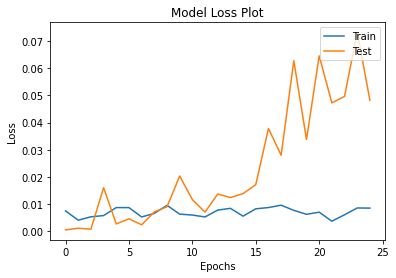

In [ ]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_pretrained_history.history['loss'])
plt.plot(cnn_pretrained_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [ ]:
model.save('cnn_pretrained_model.hdf5')

In [ ]:
model.load_weights('cnn_pretrained_model.hdf5')

In [ ]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[2049  362]
 [ 447 1142]]
precision is 0.7593085106382979
recall is  0.7186910006293267
F1 score 0.7384416424183641
specificity is 0.8498548320199087


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


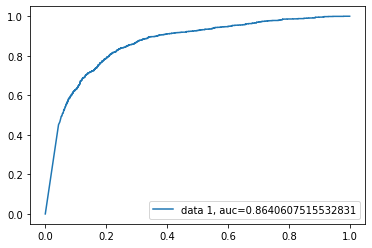

In [ ]:
Y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f = X_train[train_idx]
    y_train_f = Y_train[train_idx]
    x_val_f = X_train[val_idx]
    y_val_f = Y_train[val_idx]
    model.fit(x_train_f, y_train_f,
              batch_size=256,
              epochs=5,
              verbose = 0,
              validation_data=(x_val_f, y_val_f))
    # Get accuracy of model on validation data. It's not AUC but it's something at least!
    preds_val = model.predict([x_val_f], batch_size=256)
    preds.append(model.predict(X_test))
    fold = fold + 1
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=0)
    aucs = aucs + auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=1)
    aucs += auc(fpr,tpr)
    print('Fold {}, AUC = {}'.format(fold,auc(fpr, tpr)))
print("Cross Validation AUC = {}".format(aucs/10))   

Fold 1, AUC = 0.9999723162654968
Fold 2, AUC = 1.0
Fold 3, AUC = 1.0
Fold 4, AUC = 1.0
Fold 5, AUC = 1.0
Fold 6, AUC = 1.0
Fold 7, AUC = 1.0
Fold 8, AUC = 1.0
Fold 9, AUC = 1.0
Fold 10, AUC = 1.0
Cross Validation AUC = 1.0
